In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.metrics import accuracy_score, explained_variance_score, mean_absolute_error, mean_squared_error
%matplotlib inline 

In [3]:
rdrive = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/'
learn_gam = rdrive + 'scikit/gam_spec/'
learn_nuc = rdrive + 'scikit/nuc_conc/'

In [6]:
dets = ['nuc29', 'act32', 'act4/9', 'd1_hpge', 'd2_hpge', 'd3_czt', 'd6_sri2', 'd5_labr3', 'd4_nai']
pred = ['reactor', 'burnup', 'enrichment', 'cooling']
predmll = ['ReactorType', 'Burnup', 'Enrichment', 'CoolingTime']
csv_end = '_mimic_mll.csv'
# for dataframes
algcol = ['knn_auto', 'dtree_auto', 'knn31', 'dtree31', 'knn113', 'dtree113']
scrcol  = ['Accuracy', 'Acc Std']
errcol = ['Neg MAE', 'MAE Std']
tfrac = '_tset1.0_'

In [7]:
results = {}
for i, p in enumerate(pred):
    if p == 'reactor':
        levels = [algcol, scrcol]
    else: 
        levels = [algcol, errcol]
    df = pd.DataFrame(index=dets, columns=pd.MultiIndex.from_product(levels, names=["Algorithm", "Metric"]))
    for d in dets:
        learn_path = learn_gam
        knncsv = p + '_knn' + tfrac + d + csv_end
        dtrcsv = p + '_dtree' + tfrac + d + csv_end
        if 'nuc' in d or 'act' in d:
            if d == 'act4/9':
                knncsv = p + '_knn' + tfrac + 'act4' + csv_end
                dtrcsv = p + '_dtree' + tfrac + 'act4' + csv_end
                knn31 = pd.read_csv(learn_path + 'act4/' + knncsv).drop(columns='Unnamed: 0')
                dtr31 = pd.read_csv(learn_path + 'act4/' + dtrcsv).drop(columns='Unnamed: 0')
                knncsv = p + '_knn' + tfrac + 'act9' + csv_end
                dtrcsv = p + '_dtree' + tfrac + 'act9' + csv_end
                ##### applying act9 to auto, although this isn't accurate #####
                knn_auto = knn113 = pd.read_csv(learn_path + 'act9/' + knncsv).drop(columns='Unnamed: 0')
                dtr_auto = dtr113 = pd.read_csv(learn_path + 'act9/' + dtrcsv).drop(columns='Unnamed: 0')
            else:
                if 'nuc' in d:
                    learn_path = learn_nuc
                knn_auto = knn31 = knn113 = pd.read_csv(learn_path + d + '/' + knncsv).drop(columns='Unnamed: 0')
                dtr_auto = dtr31 = dtr113 = pd.read_csv(learn_path + d + '/' + dtrcsv).drop(columns='Unnamed: 0')
        else:
            knn_auto = pd.read_csv(learn_path + 'auto/' + knncsv).drop(columns='Unnamed: 0')
            dtr_auto = pd.read_csv(learn_path + 'auto/' + dtrcsv).drop(columns='Unnamed: 0')
            knn31 = pd.read_csv(learn_path + 'n31/' + knncsv).drop(columns='Unnamed: 0')
            dtr31 = pd.read_csv(learn_path + 'n31/' + dtrcsv).drop(columns='Unnamed: 0')
            knn113 = pd.read_csv(learn_path + 'n113/' + knncsv).drop(columns='Unnamed: 0')
            dtr113 = pd.read_csv(learn_path + 'n113/' + dtrcsv).drop(columns='Unnamed: 0')
        
        if p == 'reactor':
            sign = 1
            dfmetric = 'Accuracy'
            dfstd = 'Acc Std'
        else:
            sign = -1
            dfmetric = 'Neg MAE'
            dfstd = 'MAE Std'
        errname = 'AbsError'
        
        df.loc[d, ('knn_auto', dfmetric)] = sign * knn_auto[errname].mean()
        df.loc[d, ('knn_auto', dfstd)] = knn_auto[errname].std()
        df.loc[d, ('dtree_auto', dfmetric)] = sign * dtr_auto[errname].mean()
        df.loc[d, ('dtree_auto', dfstd)] = dtr_auto[errname].std()
        df.loc[d, ('knn113', dfmetric)] = sign * knn113[errname].mean()
        df.loc[d, ('knn113', dfstd)] = knn113[errname].std()
        df.loc[d, ('dtree113', dfmetric)] = sign * dtr113[errname].mean()
        df.loc[d, ('dtree113', dfstd)] = dtr113[errname].std()    
        df.loc[d, ('knn31', dfmetric)] = sign * knn31[errname].mean()
        df.loc[d, ('knn31', dfstd)] = knn31[errname].std()
        df.loc[d, ('dtree31', dfmetric)] = sign * dtr31[errname].mean()
        df.loc[d, ('dtree31', dfstd)] = dtr31[errname].std()
    
    results[p] = df

In [8]:
results['reactor']

Algorithm  knn_auto           dtree_auto               knn31            \
Metric     Accuracy   Acc Std   Accuracy   Acc Std  Accuracy   Acc Std   
nuc29      0.978352  0.145532   0.981203   0.13581  0.978352  0.145532   
act32      0.989228  0.103231   0.985163  0.120904  0.989228  0.103231   
act4/9     0.932893  0.250212   0.932046  0.251671  0.810298  0.392072   
d1_hpge    0.783672  0.411747   0.866057  0.340597  0.881741   0.32292   
d2_hpge     0.86582  0.340852   0.858774  0.348261  0.869275  0.337105   
d3_czt     0.794648  0.403966   0.809722  0.392527    0.8479  0.359124   
d6_sri2    0.877947  0.327352   0.849356  0.357707  0.863889  0.342912   
d5_labr3   0.863889  0.342912   0.827405  0.377903  0.863144  0.343701   
d4_nai     0.824526  0.380379   0.783503  0.411864  0.845257  0.361665   

Algorithm   dtree31              knn113            dtree113            
Metric     Accuracy   Acc Std  Accuracy   Acc Std  Accuracy   Acc Std  
nuc29      0.981203   0.13581  0.978352  0.145532  0.981203   0.13581  
act32      0.985163  0.120904  0.989228  0.103231  0.985163  0.120904  
act4/9     0.808028  0.393857  0.932893  0.250212  0.932046  0.251671  
d1_hpge    0.872629  0.333394  0.881165  0.323599  0.897154  0.303762  
d2_hpge     0.86914  0.337253  0.859316  0.347701  0.883841   0.32042  
d3_czt     0.830352  0.375329  0.848916  0.358137  0.847798  0.359223  
d6_sri2    0.840447  0.366197  0.869953  0.336361  0.867649  0.338878  
d5_labr3     0.8375  0.368915  0.866938  0.339648  0.848306   0.35873  
d4_nai     0.823069  0.381617  0.845461  0.361471  0.829201   0.37634

# Plotting

In [9]:
# color dict (use: colors['XColor'])
colors = {'DBrwn' : '#8c510a', 'MBrwn' : '#d8b365', 'LBrwn' : '#f6e8c3',
          'DTeal' : '#01665e', 'MTeal' : '#5ab4ac', 'LTeal' : '#c7eae5',
          'DPurp' : '#762a83', 'MPurp' : '#af8dc3', 'LPurp' : '#e7d4e8'
         }

In [31]:
def plot_curves(pred_param, title, plotdf):
    plt.clf()
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=20, pad=15)
    ax.set_xlabel('Detector Type', fontsize=20, labelpad=15)
    if pred_param == 'reactor':
        ax.set_ylabel('Accuracy Score', fontsize=20, labelpad=15)
        metric = scrcol[0]
        std = scrcol[1]
    else:
        err = 'Negative MAE'
        if pred_param == 'burnup':
            yaxlbl = err + ' [MWd/MTU]'
        elif pred_param == 'enrichment':
            yaxlbl = err + ' [% U235]'
        else:
            yaxlbl = err + ' [days]'
        ax.set_ylabel(yaxlbl, fontsize=20, labelpad=15)
        metric = errcol[0]
        std = errcol[1]
    
    x = ['Nuc29', 'Act32', 'Act4/9', 'L/HPGe', 'P/HPGe', 'CZT', 'SrI2', 'LaBr3', 'NaI']
    c = ['LBrwn', 'LTeal', 'MBrwn', 'MTeal', 'DBrwn', 'DTeal']
    lbl = ['kNN Auto', 'Dec Tree Auto', 'kNN 31', 'Dec Tree 31', 'kNN 113', 'Dec Tree 113']
    for i, alg in enumerate(algcol):
        y = np.array(plotdf[alg][metric], dtype=float)
        sd = np.array(plotdf[alg][std], dtype=float)
        ax.plot(x, y, 'o-', color=colors[c[i]], mew=0, ms=5, label=lbl[i])
        ax.fill_between(x, y - sd, y + sd, color=colors[c[i]], alpha=0.2)
    
    ax.tick_params(labelsize=12)
    h,l = ax.get_legend_handles_labels()
    #handles = [h[5], h[2], h[3], h[0], h[4], h[1]]
    #labels = [l[5], l[2], l[3], l[0], l[4], l[1]]
    #ax.legend(handles,labels,loc='best')
    ax.legend(loc='best')
    
    #if pred_param == 'reactor':
    #    ax.set_ylim(0.7, top=1.03)
    #elif pred_param == 'burnup':
    #    ax.set_ylim(-1200, top=-100)
    #elif pred_param == 'enrichment':
    #    ax.set_ylim(None, top=0.1)
    #else:
    #    ax.set_ylim(-300, top=30)
    plt.show()

<Figure size 432x288 with 0 Axes>

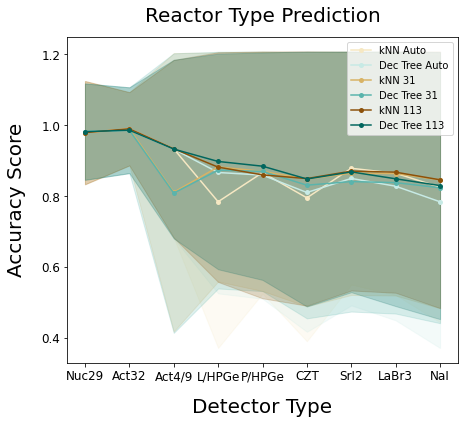

In [32]:
pred_param = 'reactor'
plot_curves(pred_param, 'Reactor Type Prediction', results[pred_param])

<Figure size 432x288 with 0 Axes>

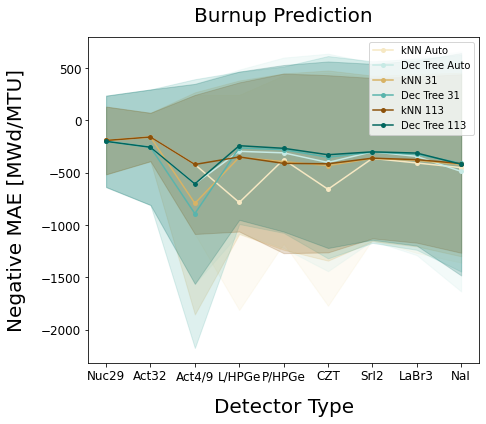

In [33]:
pred_param = 'burnup'
plot_curves(pred_param, 'Burnup Prediction', results[pred_param])

<Figure size 432x288 with 0 Axes>

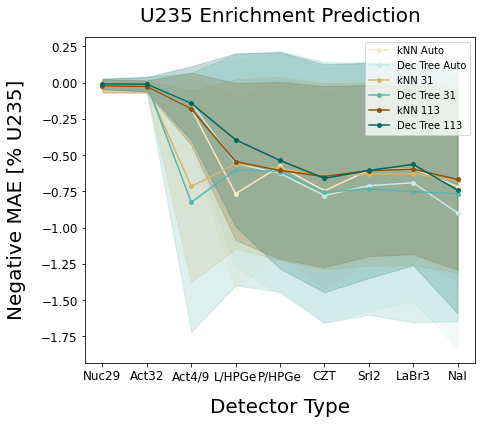

In [34]:
pred_param = 'enrichment'
plot_curves(pred_param, 'U235 Enrichment Prediction', results[pred_param])

<Figure size 432x288 with 0 Axes>

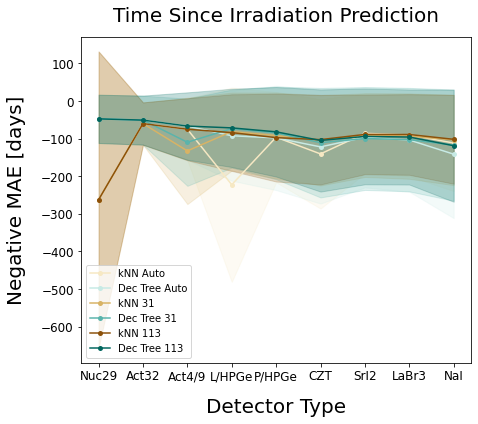

In [35]:
pred_param = 'cooling'
plot_curves(pred_param, 'Time Since Irradiation Prediction', results[pred_param])